In [1]:
!pip install wfdb --quiet
!pip install keras-tuner --quiet
!pip install resnet1d --quiet
!pip install tqdm --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 4.4 MB/s eta 0:00:00
ERROR: Could not find a version that satisfies the requirement resnet1d (from versions: none)
ERROR: No matching distribution found for resnet1d


In [2]:
import wfdb
from scipy.signal import butter, filtfilt
import numpy as np
from scipy.signal import resample
from re import S
import os

In [3]:
def bandpass_filter(signal, fs=250, lowcut=0.5,  highcut=15.0,  order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)
    
def smooth_signal(data, window_size=5):
    window = np.ones(window_size) / window_size
    smoothed = np.convolve(data, window, mode='same')
    return smoothed
def normalize_signal(data):
    return (data - np.mean(data)) / np.std(data)

In [4]:

from scipy.signal import resample

def resample_signal(signal, original_fs, target_fs):
    num_samples = int(len(signal) * target_fs / original_fs)
    resampled_signal = resample(signal, num_samples)
    return resampled_signal
def adjust_annotations(samples, original_fs, target_fs):
    scale = target_fs / original_fs
    if isinstance(samples, (list, np.ndarray)):
        return (np.array(samples) * scale).astype(int)
    else:
        return int(samples * scale)



In [5]:


def extract_wave_regions(samples, symbols, fs, extra_ms={'p':0,'N':20,'t':0}):
    wave_regions = {'p': [], 'N': [], 't': []}
    start = None
    qrs_symbols = ['N', 'L', 'R', 'V', 'A','/']
    current_symbol = None
    a = fs/ 1000
    for i in range(len(symbols)):

        if symbols[i] == '(':
            start = samples[i]
            current_symbol = None
        elif symbols[i] in wave_regions:

            current_symbol = symbols[i]
        elif symbols[i] in qrs_symbols:
            current_symbol = 'N'
        elif symbols[i] == ')' and current_symbol:
            end = samples[i]
            if start and end and current_symbol:
              #print(extra_ms['p'])
              wave_regions[current_symbol].append((int(start-extra_ms[current_symbol]*a), int(end+extra_ms[current_symbol]*a)))

            start = None
            current_symbol = None
    return wave_regions


In [6]:
def create_multi_class_mask(length, wave_regions):

    mask = np.zeros((length, 4))  # [BG, P, QRS, T]
    label_map = {'p': 1, 'N': 2, 't': 3}
    for label, regions in wave_regions.items():
        for start, end in regions:
            start = max(0, start)
            end = min(length, end)
            mask[start:end, label_map[label]] = 1

    mask[:, 0] = (mask[:, 1:] == 0).all(axis=1).astype(float)
    return mask

In [7]:
def segment_signal_and_mask(signal, mask, window_size, stride):
    segments, masks = [], []
    for i in range(0, len(signal) - window_size + 1, stride):
        segment = signal[i:i + window_size]
        mask_segment = mask[i:i + window_size]
        if len(segment) == window_size and len(mask_segment) == window_size:
            segments.append(segment)
            masks.append(mask_segment)
    return np.array(segments), np.array(masks)


In [8]:
import matplotlib.pyplot as plt
import numpy as np

def display_ecg_with_masks(signal, mask, fs=250):
    
    time = np.arange(len(signal)) / fs 
    if mask.ndim == 1:
        num_classes = 4  
        mask = np.eye(num_classes)[mask]  

    plt.figure(figsize=(15, 6))
    plt.plot(time, signal, color='black', label='ECG Signal')

    plt.fill_between(time, -1, 1, where=mask[:, 0] > 0.5, color='gray', alpha=0.3, label='background')
    plt.fill_between(time, -1, 1, where=mask[:, 1] > 0.5, color='blue', alpha=0.3, label='P wave')
    plt.fill_between(time, -1, 1, where=mask[:, 2] > 0.5, color='red', alpha=0.3, label='QRS Complex')
    plt.fill_between(time, -1, 1, where=mask[:, 3] > 0.5, color='green', alpha=0.3, label='T wave')

    plt.title("ECG Signal with Annotated Wave Regions")
    plt.xlabel("Time (seconds)")
    plt.ylabel("Amplitude")
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show()


In [9]:
import numpy as np
import wfdb

def process_record(record_path, Type='LUDB', extra_ms={'p':0,'N':20,'t':0}, target_fs=250, window_sec=1.0):
    record = wfdb.rdrecord(record_path)
    signal = record.p_signal[:, 0]  # lead I
    fs = record.fs

    annotations = wfdb.rdann(record_path, 'pu0' if Type == 'QTDB' else 'i')
    samples = annotations.sample
    symbols = annotations.symbol

    window_size = 240
    stride = window_size // 4  
    
    remainder = (len(signal) - window_size) % stride
    padding = (stride - remainder) if remainder != 0 else 0
    if padding > 0:
        signal = np.pad(signal, (0, padding), mode='constant', constant_values=signal[-1])

    
    signal = normalize_signal(smooth_signal(bandpass_filter(signal, fs=fs)))
    if fs != target_fs:
        signal = resample_signal(signal, original_fs=fs, target_fs=target_fs)
        samples = adjust_annotations(samples, original_fs=fs, target_fs=target_fs)
        fs = target_fs

    wave_regions = extract_wave_regions(samples, symbols, fs, extra_ms=extra_ms)
    mask = create_multi_class_mask(len(signal), wave_regions)

    indices = np.where(mask[:, 0] != 1)[0] 
    first_non_zero_row = indices[0] if len(indices) > 0 else None
    last_non_zero_row = indices[-1] if len(indices) > 0 else None
    

    padding = 5
    first_non_zero_row-=padding
    if (first_non_zero_row<0):first_non_zero_row=0
    last_non_zero_row+=padding
    if (last_non_zero_row>len(signal)-1):last_non_zero_row=len(signal)-1
    mask=mask[first_non_zero_row:last_non_zero_row]
    signal=signal[first_non_zero_row:last_non_zero_row]
    
    segments, masks = segment_signal_and_mask(signal, mask, window_size, stride)


    if len(segments) * stride + window_size - stride < len(signal):
        pad_needed = len(signal) - (len(segments) * stride + window_size - stride)
        signal = np.pad(signal, (0, pad_needed), mode='constant', constant_values=signal[-1])
        mask = np.pad(mask, (0, pad_needed), mode='constant', constant_values=0)  


    segments = np.expand_dims(segments, axis=1) 


    masks = np.argmax(masks, axis=-1)            

    return segments, masks


In [10]:
def get_all_records(directory, extension=".dat"):
    files = [f.replace(extension, "") for f in os.listdir(directory) if f.endswith(extension)]
    return list(set(files))  
path='/kaggle/input/qtdb-ludb/'
qtdb_path = path + "physionet.org/files/qtdb/1.0.0/"
ludb_path = path + "physionet.org/files/ludb/1.0.1/data/"


qt_records = get_all_records(qtdb_path)
lu_records = get_all_records(ludb_path)

print(f"Found {len(qt_records)} QTDB records and {len(lu_records)} LUDB records.")

Found 105 QTDB records and 200 LUDB records.


Processing QTDB Records: 100%|██████████| 105/105 [00:16<00:00,  6.25it/s]


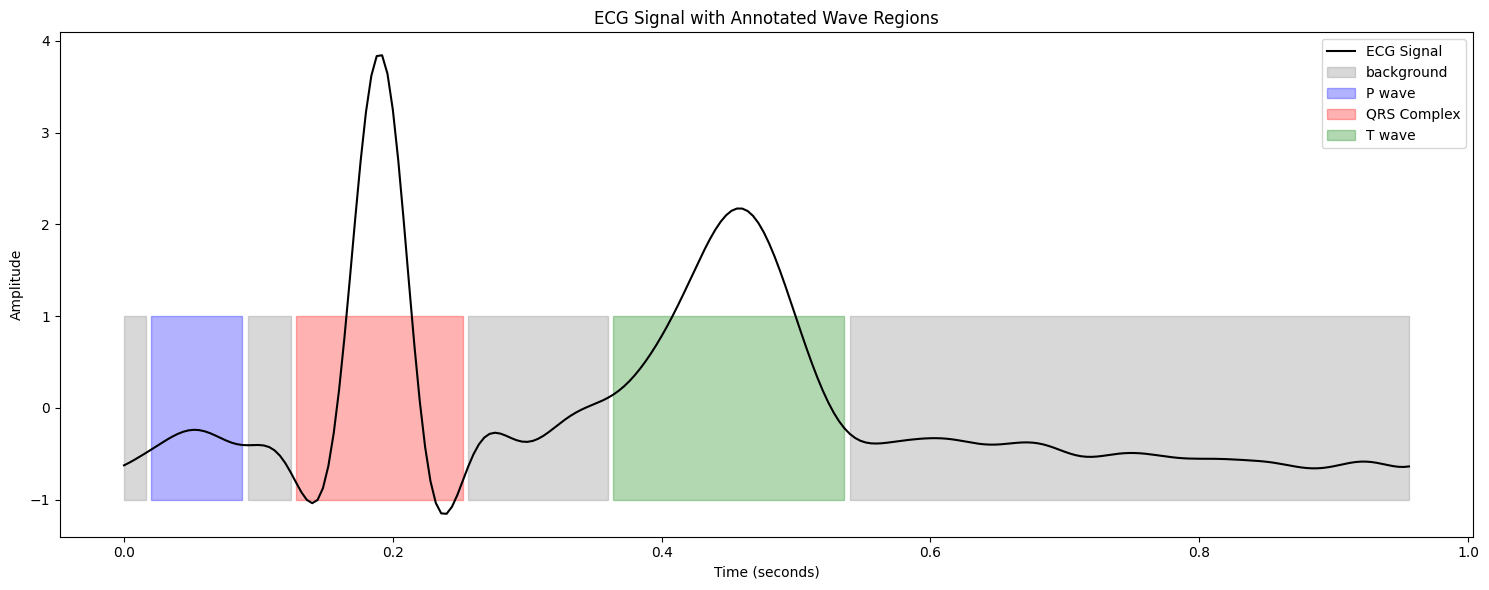

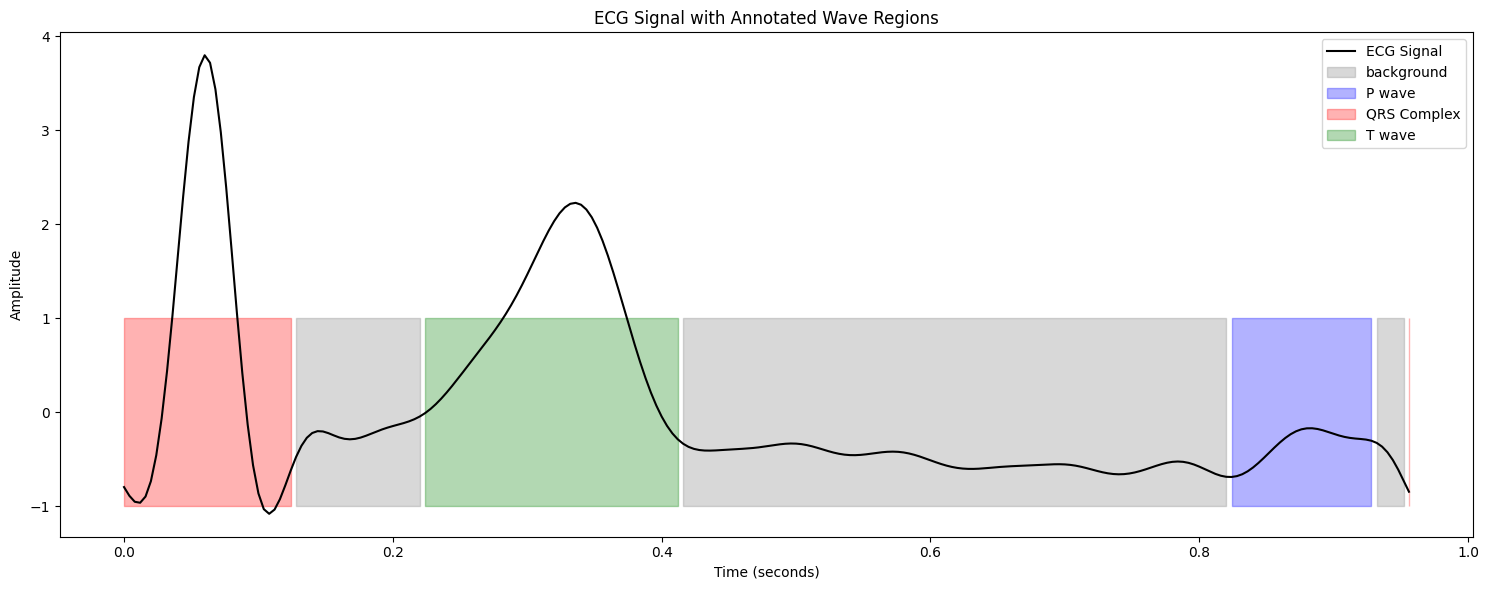

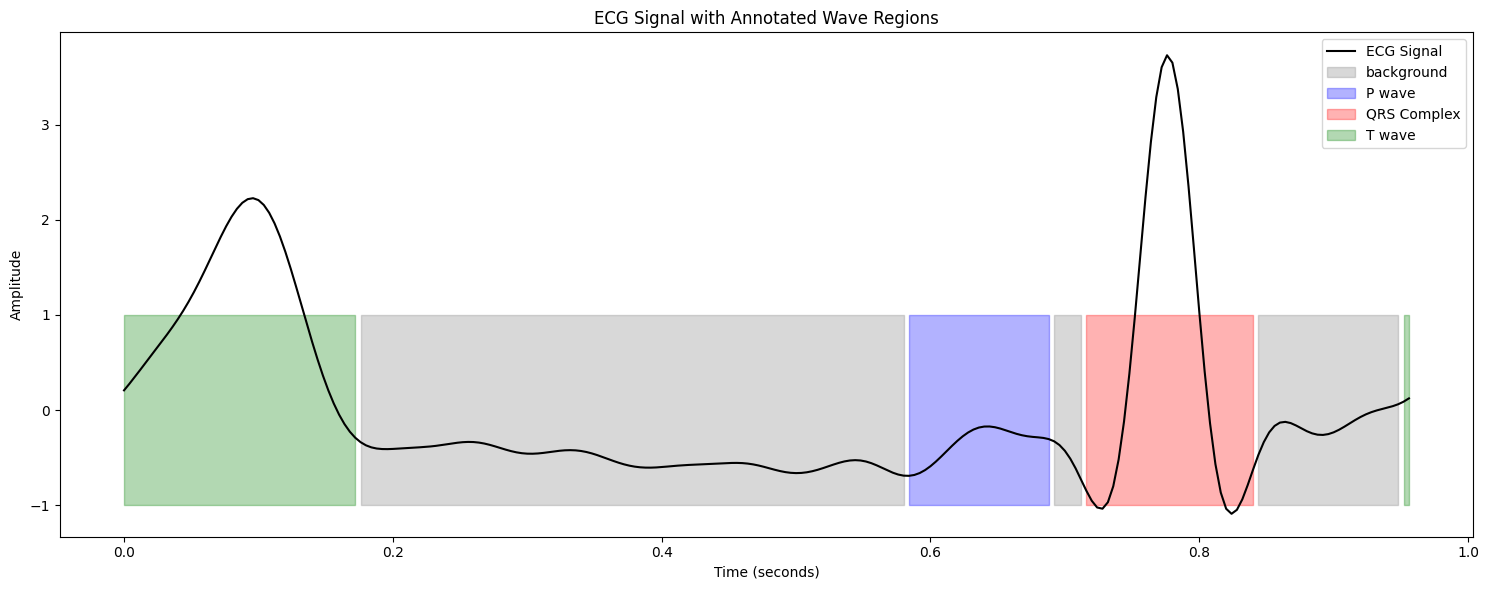

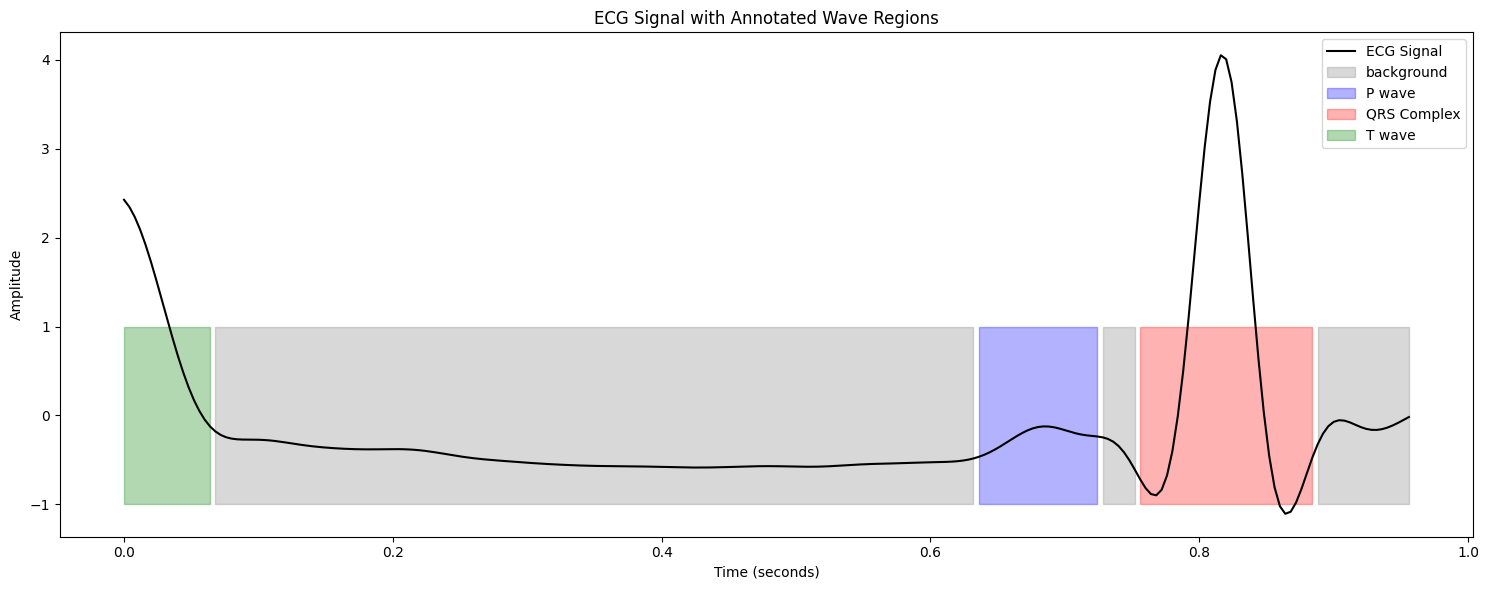

In [11]:
from tqdm import tqdm
qt_segments_list, qt_masks_list = [], []

for record_path in tqdm(qt_records, desc="Processing QTDB Records"):
#if(True):
#    record_path = "sel232"
    try:

        #print(f"Processing {record_path}")
        segments, masks = process_record(qtdb_path+record_path, Type='QTDB', extra_ms={'p':0,'N':20,'t':0},target_fs=250)  
        qt_segments_list.append(segments)
        qt_masks_list.append(masks)

    except:
        print(f"Skipping {record_path} due to error.")

display_ecg_with_masks(segments[0].flatten(), masks[0])
display_ecg_with_masks(segments[17].flatten(), masks[17])
display_ecg_with_masks(segments[18].flatten(), masks[18])
display_ecg_with_masks(segments[-1].flatten(), masks[-1])



Processing LUDB Records: 100%|██████████| 200/200 [00:04<00:00, 44.78it/s]


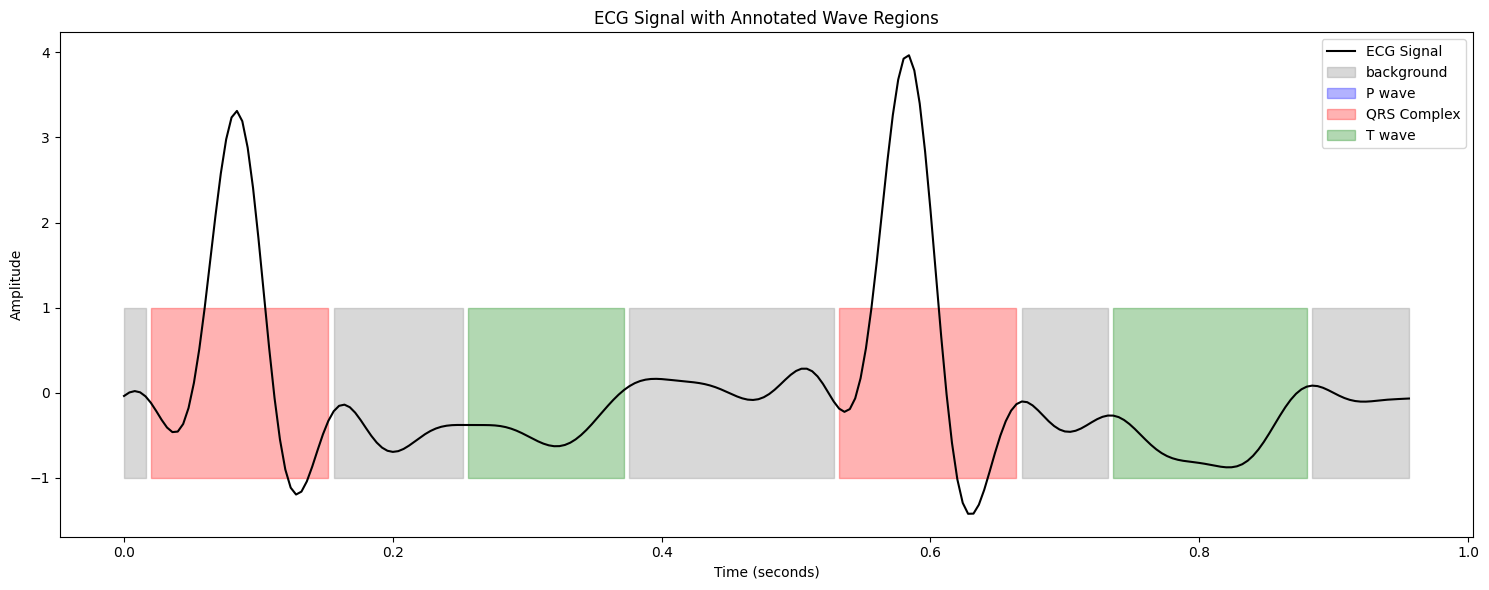

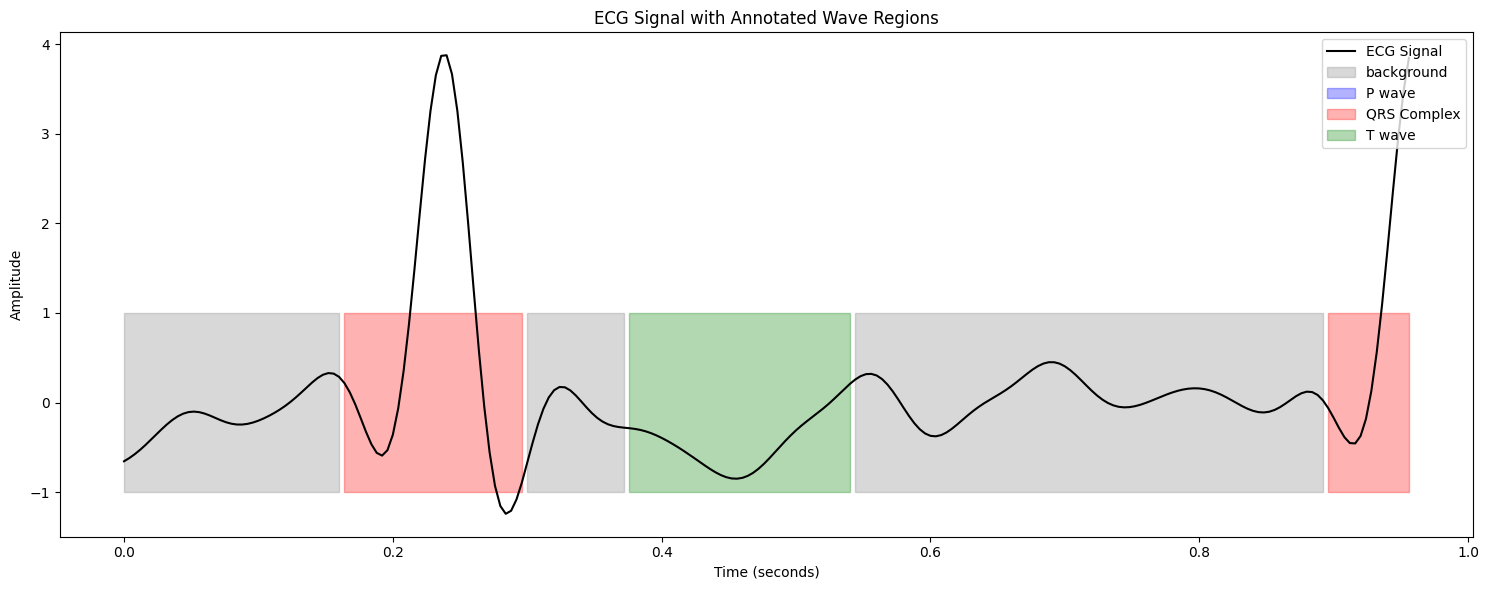

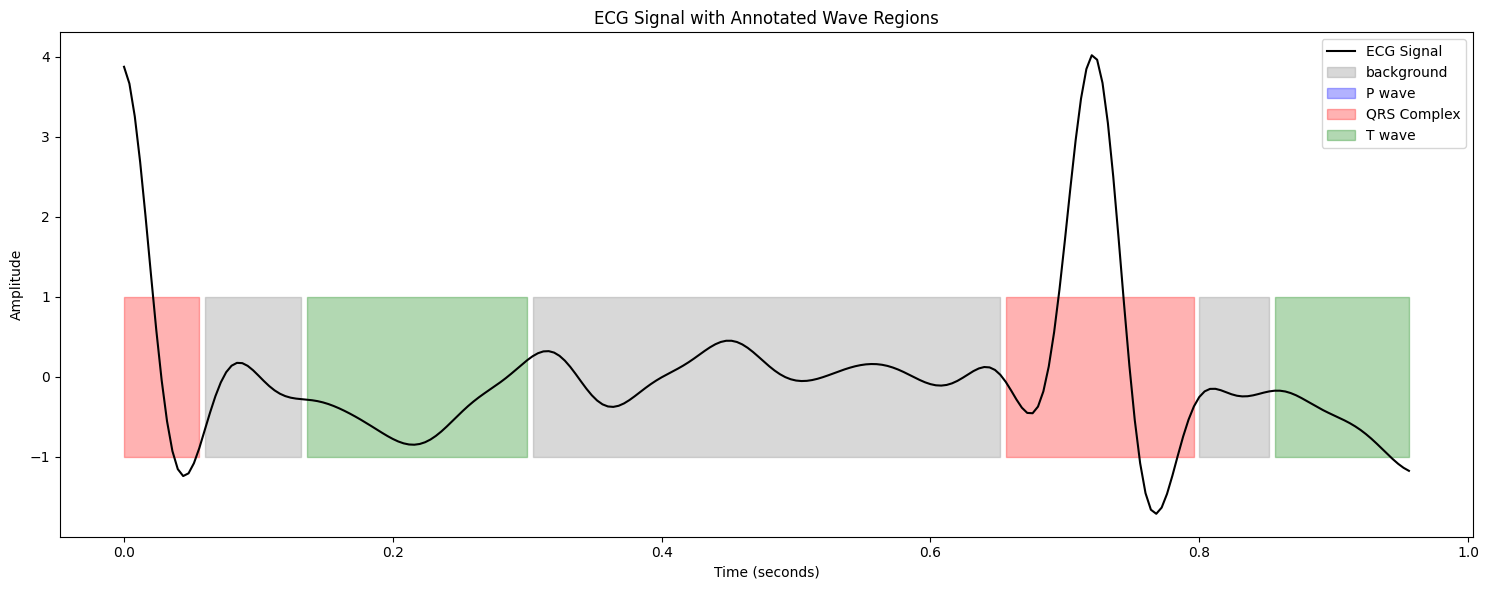

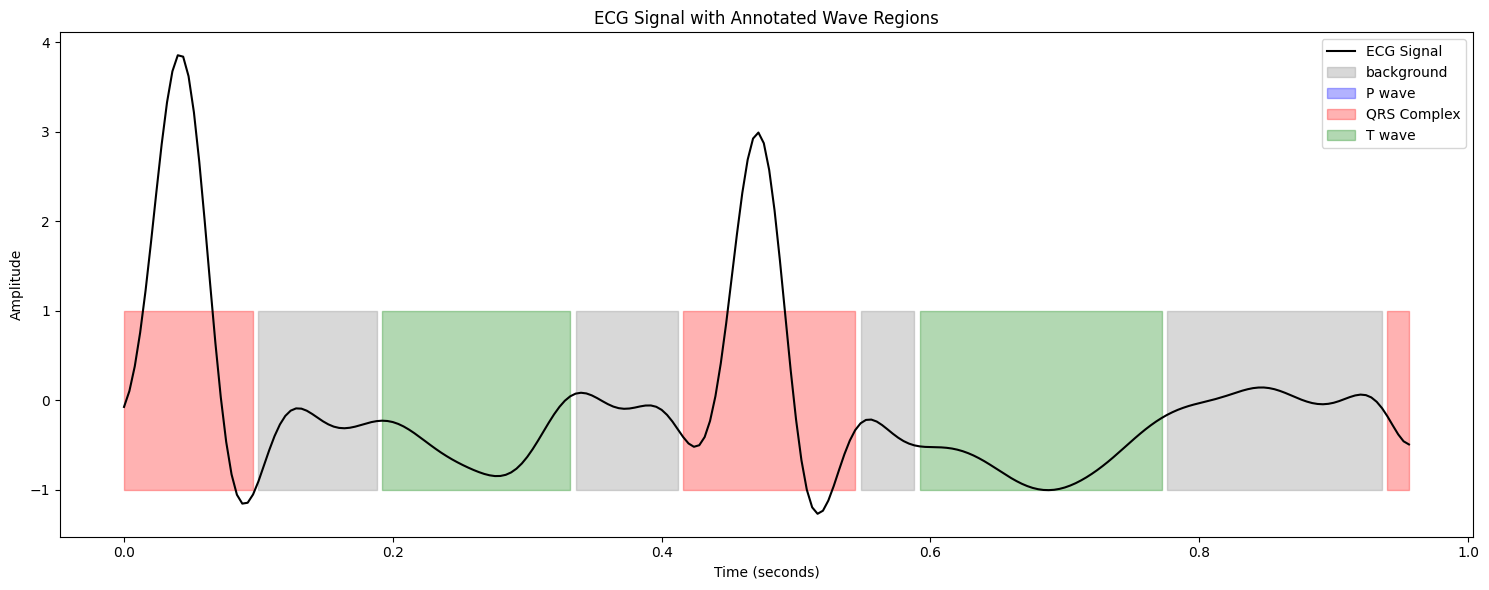

In [12]:


lu_segments_list, lu_masks_list = [], []

for record_path in tqdm(lu_records, desc="Processing LUDB Records"):
    try:

        segments, masks = process_record(
            ludb_path + record_path,
            Type='LUDB',
            extra_ms={'p':0, 'N':20, 't':0},
            target_fs=250
        )
        lu_segments_list.append(segments)
        lu_masks_list.append(masks)

    except Exception as e:
        print(f"Skipping {record_path} due to error: {e}")




display_ecg_with_masks(segments[0].flatten(), masks[0])
display_ecg_with_masks(segments[17].flatten(), masks[17])
display_ecg_with_masks(segments[18].flatten(), masks[18])
display_ecg_with_masks(segments[-1].flatten(), masks[-1])

In [13]:
qt_segments = np.concatenate(qt_segments_list, axis=0)
qt_masks = np.concatenate(qt_masks_list, axis=0)
lu_segments = np.concatenate(lu_segments_list, axis=0)
lu_masks = np.concatenate(lu_masks_list, axis=0)

In [14]:

X = np.concatenate([qt_segments, lu_segments])

qt_segments = None
lu_segments = None
qt_segments_list = None
lu_segments_list = None

In [15]:

y = np.concatenate([qt_masks, lu_masks])
print(y)

[[0 0 0 ... 0 0 0]
 [2 2 2 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [2 2 2 ... 2 2 2]
 [3 3 3 ... 3 3 3]
 [2 2 2 ... 2 2 2]]


In [16]:
import numpy as np

flat_y = y.flatten()

# Count occurrences of each class
unique_classes, class_counts = np.unique(flat_y, return_counts=True)

# Compute total number of labels
total_labels = np.sum(class_counts)
from re import S
import os
# Compute class weights
class_weights = class_counts / total_labels

# Display results
class_weight_dict = dict(zip(unique_classes, class_weights))
print("Class Counts:", dict(zip(unique_classes, class_counts)))
print("Class Weights (Relative Frequency):", class_weight_dict)

# Get weight of class 0
weight_0 = class_weight_dict.get(0, 0)
print(f"Weight of Class 0: {weight_0:.4f}")


Class Counts: {0: 45861096, 1: 9742522, 2: 17298084, 3: 22661258}
Class Weights (Relative Frequency): {0: 0.47990451530593026, 1: 0.10194872574060075, 2: 0.1810124341062688, 3: 0.2371343248472002}
Weight of Class 0: 0.4799


In [17]:
qt_masks = None
lu_masks = None
qt_masks_list = None
lu_masks_list = None

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)


In [19]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv1D, MaxPooling1D, LSTM, Dense, 
    Dropout, BatchNormalization, TimeDistributed,
    Flatten,Permute
)
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv1D, BatchNormalization, Activation,
    Add, Dropout, Dense
)

def residual_block(x, filters, kernel_size, dilation_rate):
    # Shortcut connection
    shortcut = x
    
    x = Conv1D(filters, kernel_size, padding='same', dilation_rate=dilation_rate)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.2)(x)
    
    x = Conv1D(filters, kernel_size, padding='same', dilation_rate=dilation_rate)(x)
    x = BatchNormalization()(x)
    
    # Match dimensions if needed
    if shortcut.shape[-1] != filters:
        shortcut = Conv1D(filters, 1, padding='same')(shortcut)
        shortcut = BatchNormalization()(shortcut)
    
    # Add shortcut
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

def build_tcn_model(input_length=240, num_classes=4):
    inputs = Input(shape=(1, input_length))
    
    x = Permute((2, 1))(inputs)
    
    x = Conv1D(64, 5, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # Stack of residual blocks with increasing dilation rates
    dilation_rates = [1, 2, 4, 8, 16, 32]
    for rate in dilation_rates:
        x = residual_block(x, filters=64, kernel_size=5, dilation_rate=rate)
    
    # Additional processing
    x = Conv1D(128, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv1D(64, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

2025-06-05 04:12:12.861939: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749096733.042250      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749096733.096467      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [20]:
model = build_tcn_model(input_length=240, num_classes=4)
model.summary()

I0000 00:00:1749096745.469644      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 1, 240)         │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ permute (Permute)         │ (None, 240, 1)         │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d (Conv1D)           │ (None, 240, 64)        │            384 │ permute[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 240, 64)        │            256 │ conv1d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 240, 64)        │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_1 (Conv1D)         │ (None, 240, 64)        │         20,544 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 240, 64)        │            256 │ conv1d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 240, 64)        │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 240, 64)        │              0 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_2 (Conv1D)         │ (None, 240, 64)        │         20,544 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 240, 64)        │            256 │ conv1d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 240, 64)        │              0 │ batch_normalization_2… │
│                           │                        │                │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 240, 64)        │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_3 (Conv1D)         │ (None, 240, 64)        │         20,544 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 240, 64)        │            256 │ conv1d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 240, 64)        │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 240, 64)        │              0 │ activation_3[0][0]     │
├──────────────────────

 Total params: 300,612 (1.15 MB)

 Trainable params: 298,564 (1.14 MB)

 Non-trainable params: 2,048 (8.00 KB)

In [21]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf


In [22]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32
)

test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")

Epoch 1/50


I0000 00:00:1749096763.224891      83 service.cc:148] XLA service 0x7e73600362b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749096763.225620      83 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
W0000 00:00:1749096764.087207      83 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
I0000 00:00:1749096764.712665      83 cuda_dnn.cc:529] Loaded cuDNN version 90300


   9/9955 ━━━━━━━━━━━━━━━━━━━━ 2:21 14ms/step - accuracy: 0.4082 - loss: 1.4733

I0000 00:00:1749096774.540895      83 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


9953/9955 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9116 - loss: 0.2267

W0000 00:00:1749096905.405717      84 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


9955/9955 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9116 - loss: 0.2267

W0000 00:00:1749096916.362508      86 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1749096924.278650      84 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


9955/9955 ━━━━━━━━━━━━━━━━━━━━ 176s 15ms/step - accuracy: 0.9116 - loss: 0.2267 - val_accuracy: 0.9373 - val_loss: 0.1561
Epoch 2/50
9955/9955 ━━━━━━━━━━━━━━━━━━━━ 138s 14ms/step - accuracy: 0.9369 - loss: 0.1580 - val_accuracy: 0.9425 - val_loss: 0.1430
Epoch 3/50
9955/9955 ━━━━━━━━━━━━━━━━━━━━ 139s 14ms/step - accuracy: 0.9410 - loss: 0.1470 - val_accuracy: 0.9461 - val_loss: 0.1349
Epoch 4/50
9955/9955 ━━━━━━━━━━━━━━━━━━━━ 138s 14ms/step - accuracy: 0.9430 - loss: 0.1412 - val_accuracy: 0.9482 - val_loss: 0.1296
Epoch 5/50
9955/9955 ━━━━━━━━━━━━━━━━━━━━ 138s 14ms/step - accuracy: 0.9448 - loss: 0.1367 - val_accuracy: 0.9492 - val_loss: 0.1265
Epoch 6/50
9955/9955 ━━━━━━━━━━━━━━━━━━━━ 139s 14ms/step - accuracy: 0.9462 - loss: 0.1329 - val_accuracy: 0.9466 - val_loss: 0.1328
Epoch 7/50
9955/9955 ━━━━━━━━━━━━━━━━━━━━ 138s 14ms/step - accuracy: 0.9471 - loss: 0.1308 - val_accuracy: 0.9492 - val_loss: 0.1261
Epoch 8/50
9955/9955 ━━━━━━━━━━━━━━━━━━━━ 138s 14ms/step - accuracy: 0.9479 - lo

W0000 00:00:1749103508.345474      83 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


623/623 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9558 - loss: 0.1100
Test Accuracy: 0.9563


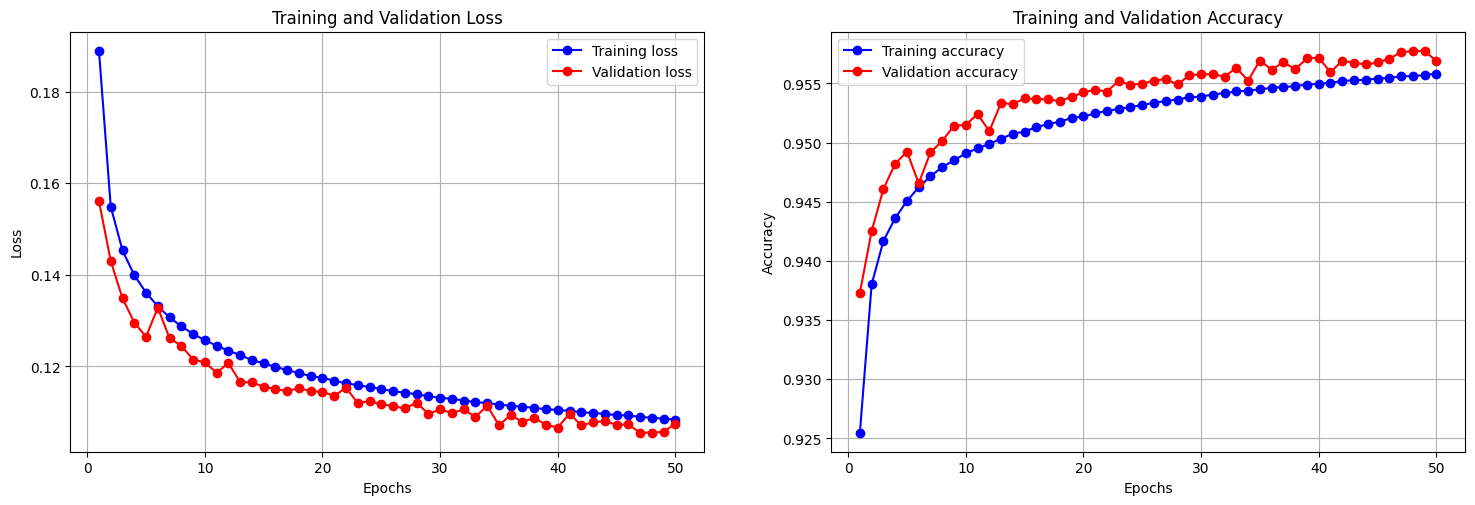

In [23]:
train_losses = history.history['loss']
val_losses = history.history['val_loss']
train_accs = history.history['accuracy']
val_accs = history.history['val_accuracy']

epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(18, 12))

# Plot Loss
plt.subplot(2, 2, 1)
plt.plot(epochs, train_losses, 'bo-', label='Training loss')
plt.plot(epochs, val_losses, 'ro-', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
# Plot Accuracy
plt.subplot(2, 2, 2)
plt.plot(epochs, train_accs, 'bo-', label='Training accuracy')
plt.plot(epochs, val_accs, 'ro-', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)


In [24]:
# Evaluate on the test set
test_loss, test_acc = model.evaluate(X_test, y_test)

print(f"Test Accuracy: {test_acc} , Test Loss: {test_loss}")

# Predict on the test set
y_pred = model.predict(X_test)

623/623 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9558 - loss: 0.1100
Test Accuracy: 0.9563308954238892 , Test Loss: 0.10917706787586212
623/623 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step


In [25]:
y_pred1 = (y_pred > 0.5).astype(int)  # Convert probabilities to binary masks
# One-hot encoding
num_classes = 4
y_test1 = np.eye(num_classes)[y_test]

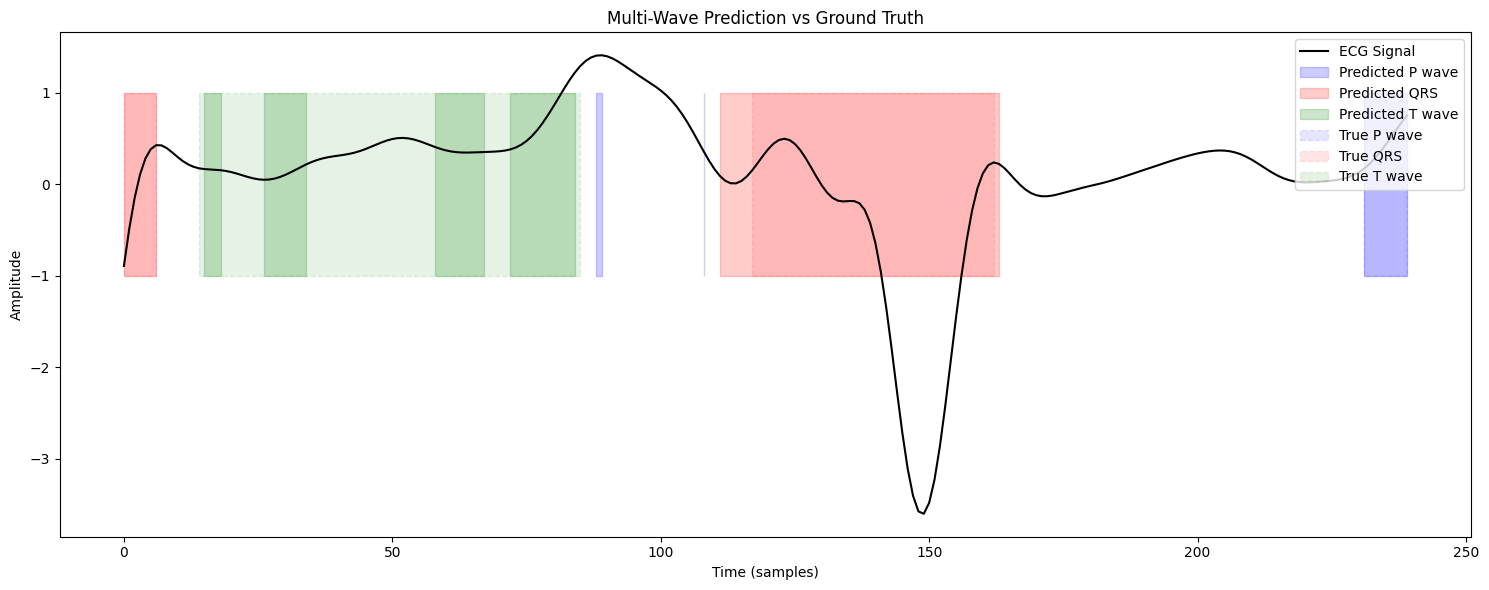

In [26]:
import matplotlib.pyplot as plt
import numpy as np

index = 0  # Sample to visualize
signal = X_test[index].flatten()
pred_mask = y_pred1[index]

true_mask = y_test1[index].astype(int)
time = np.arange(len(signal))

plt.figure(figsize=(15, 6))
plt.plot(time, signal, color='black', label='ECG Signal')

# Plot predicted masks
plt.fill_between(time, -1, 1, where=pred_mask[:, 1] > 0.5, color='blue', alpha=0.2, label='Predicted P wave')
plt.fill_between(time, -1, 1, where=pred_mask[:, 2] > 0.5, color='red', alpha=0.2, label='Predicted QRS')
plt.fill_between(time, -1, 1, where=pred_mask[:, 3] > 0.5, color='green', alpha=0.2, label='Predicted T wave')

# Plot ground truth masks
plt.fill_between(time, -1, 1, where=true_mask[:, 1] > 0.5, color='blue', alpha=0.1, label='True P wave', linestyle='dashed')
plt.fill_between(time, -1, 1, where=true_mask[:, 2] > 0.5, color='red', alpha=0.1, label='True QRS', linestyle='dashed')
plt.fill_between(time, -1, 1, where=true_mask[:, 3] > 0.5, color='green', alpha=0.1, label='True T wave', linestyle='dashed')

plt.title('Multi-Wave Prediction vs Ground Truth')
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()


In [27]:
model.save('TCN.keras') 


# testing model on ecg signal

In [28]:
def predict_full_ecg(signal, model, fs=250, window_size=240):
    
    signal = signal[:len(signal) - (len(signal) % window_size)]  
    signal = normalize_signal(smooth_signal(bandpass_filter(signal, fs=fs)))
    
    target_fs = 250
    if fs != target_fs:
        signal = resample_signal(signal, original_fs=fs, target_fs=target_fs)
    
    signal = signal.reshape(1, 1, -1)  # (1, 1, L)
    
    segments = []
    predictions = []
    
    for i in range(0, signal.shape[2] - window_size + 1, window_size):
        window = signal[:, :, i:i+window_size]
        segments.append(window)
        
        output = model.predict(window, verbose=0)  # (1, 240, 4)
        pred = np.argmax(output, axis=-1)[0]  # (240,)
        predictions.append(pred)
    
    full_prediction = np.concatenate(predictions)
    return full_prediction, segments, predictions

In [29]:
def get_wave_boundaries(predicted_labels):
    wave_types = {1: 'P', 2: 'QRS', 3: 'T'}
    wave_boundaries = {k: [] for k in wave_types.values()}

    current_class = None
    start = None

    for i, label in enumerate(predicted_labels):
        if label in wave_types:
            if current_class is None:
                current_class = label
                start = i
            elif label != current_class:
                wave_boundaries[wave_types[current_class]].append((start, i-1))
                current_class = label
                start = i
        else:

            if current_class is not None:
                wave_boundaries[wave_types[current_class]].append((start, i-1))
                current_class = None
                start = None

    # Handle last segment
    if current_class is not None:
        wave_boundaries[wave_types[current_class]].append((start, len(predicted_labels)-1))

    return wave_boundaries


In [30]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_boundaries(signal, boundaries, fs=250, zoom=(0, None)):
    time = np.arange(len(signal)) / fs  # in seconds

    plt.figure(figsize=(18, 6))
    plt.plot(time, signal, color='black', label='ECG Signal', linewidth=1)

    wave_colors = {'P': 'blue', 'QRS': 'red', 'T': 'green'}

    for wave_type, regions in boundaries.items():
        for start, end in regions:
            plt.fill_between(
                time[start:end],
                -1, 1,
                color=wave_colors.get(wave_type, 'gray'),
                alpha=0.3,
                label=f'Predicted {wave_type}'
            )

    # Prevent duplicate labels in legend
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), loc='upper right')

    plt.title("ECG Signal with Predicted Wave Regions", fontsize=16)
    plt.xlabel("Time (seconds)")
    plt.ylabel("Amplitude")
    plt.tight_layout()

    # Optional zoom
    if zoom[1] is None:
        plt.xlim(zoom[0], time[-1])
    else:
        plt.xlim(zoom)

    plt.show()


6000
{'P': [(960, 969), (1179, 1183), (2381, 2394), (2599, 2608), (2612, 2614), (3801, 3810), (4014, 4036), (5040, 5045), (5049, 5059), (5220, 5253), (5432, 5447), (5620, 5625), (5628, 5638), (5848, 5857), (5861, 5861), (5868, 5870)], 'QRS': [(0, 53), (197, 260), (404, 467), (601, 665), (803, 863), (996, 1030), (1191, 1245), (1410, 1471), (1617, 1677), (1818, 1883), (2020, 2085), (2222, 2285), (2418, 2452), (2454, 2456), (2615, 2661), (2675, 2676), (2826, 2889), (3033, 3102), (3243, 3304), (3447, 3507), (3645, 3705), (3839, 3874), (4039, 4089), (4237, 4306), (4457, 4518), (4661, 4724), (4868, 4932), (5063, 5131), (5262, 5296), (5465, 5509), (5653, 5719), (5871, 5937)], 'T': [(57, 134), (261, 348), (473, 477), (479, 481), (486, 536), (542, 545), (674, 675), (690, 690), (697, 740), (873, 941), (950, 955), (1035, 1035), (1039, 1131), (1246, 1343), (1472, 1554), (1680, 1762), (1895, 1968), (2088, 2159), (2162, 2166), (2170, 2172), (2286, 2286), (2288, 2377), (2461, 2547), (2663, 2674), (26

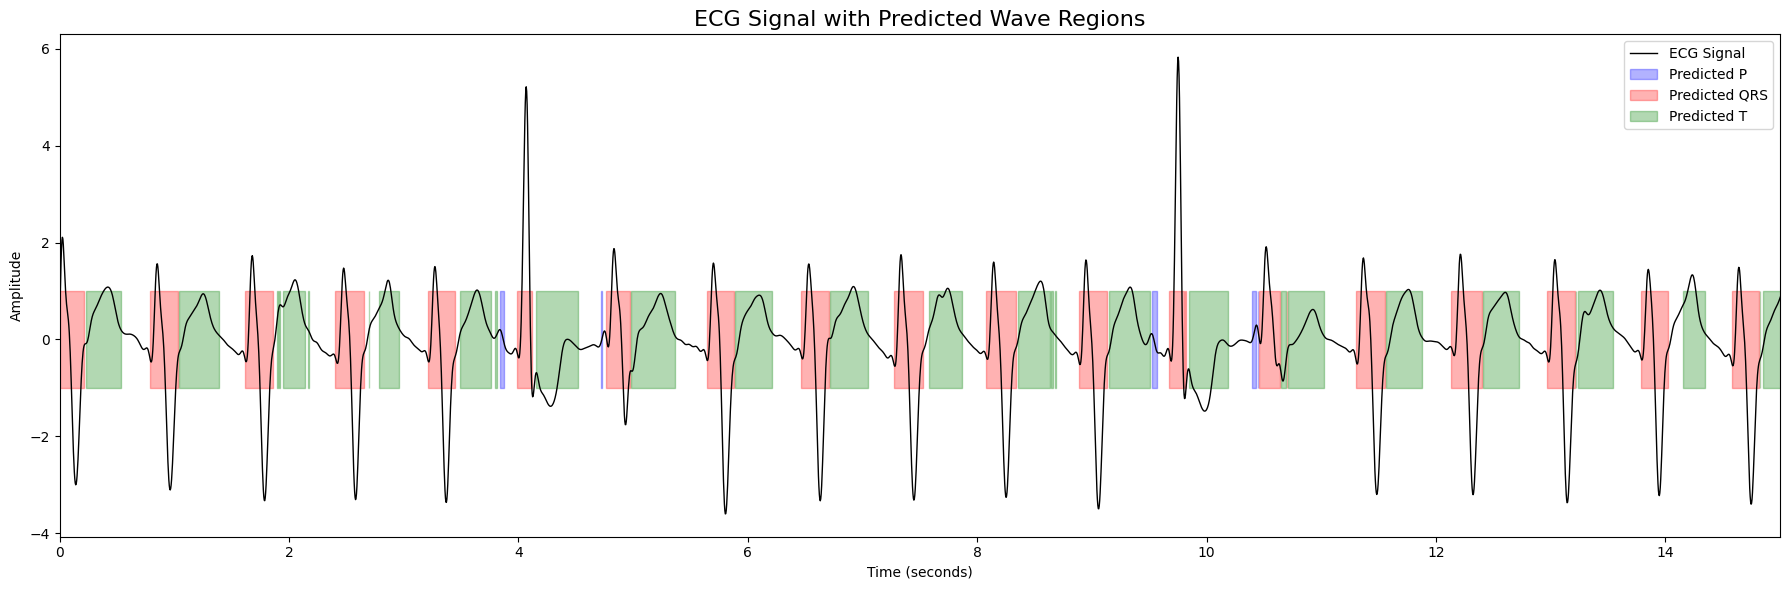

In [31]:

#record = wfdb.rdrecord('/content/drive/MyDrive/Final project/dataset/physionet.org/files/ecgiddb/1.0.0/Person_48/rec_1')

record = wfdb.rdrecord(path+'/physionet.org/files/mitdb/1.0.0/104')
signal = record.p_signal[:, 0]  # lead I
fs = record.fs
signal=signal[(10):(25*fs)]

# Predict
pred_labels, segments, _ = predict_full_ecg(signal, model, fs=fs)
signal = np.concatenate(segments, axis=2)
signal = signal.reshape(-1)
print(len(signal))
# Extract wave start/end
boundaries = get_wave_boundaries(pred_labels)
print(boundaries)
visualize_boundaries(signal, boundaries, fs=250, zoom=(0, 15))

6000
{'P': [(138, 165), (331, 334), (339, 358), (523, 550), (714, 737), (894, 921), (1090, 1108), (1271, 1294), (1458, 1485), (1642, 1671), (1830, 1856), (2019, 2044), (2206, 2232), (2393, 2420), (2580, 2606), (2766, 2793), (2961, 2986), (3149, 3174), (3335, 3363), (3530, 3534), (3537, 3554), (3718, 3745), (3905, 3932), (4093, 4119), (4289, 4313), (4481, 4506), (4667, 4668), (4674, 4693), (4858, 4888), (5054, 5082), (5246, 5272), (5434, 5462), (5626, 5652), (5814, 5843)], 'QRS': [(0, 14), (169, 202), (366, 396), (557, 588), (744, 773), (928, 957), (1115, 1144), (1302, 1332), (1490, 1520), (1676, 1706), (1864, 1894), (2051, 2080), (2238, 2267), (2427, 2457), (2613, 2642), (2800, 2830), (2993, 3022), (3181, 3210), (3369, 3400), (3563, 3592), (3750, 3780), (3938, 3968), (4126, 4157), (4319, 4349), (4513, 4542), (4700, 4730), (4896, 4926), (5087, 5117), (5278, 5307), (5469, 5499), (5659, 5688), (5849, 5879)], 'T': [(32, 78), (218, 263), (419, 461), (611, 651), (792, 836), (979, 1019), (116

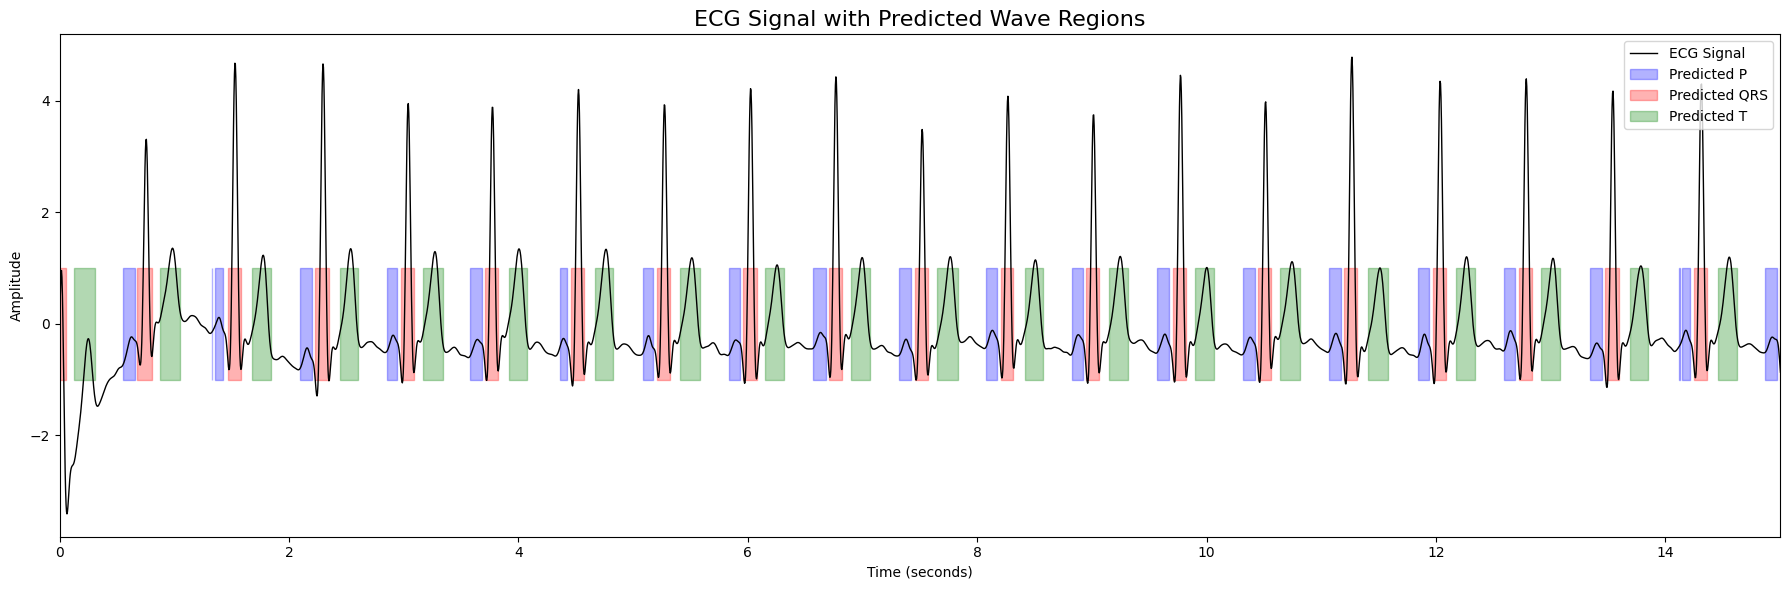

In [32]:


#record = wfdb.rdrecord('/content/drive/MyDrive/Final project/dataset/physionet.org/files/ecgiddb/1.0.0/Person_48/rec_1')

record = wfdb.rdrecord(path+'/physionet.org/files/mitdb/1.0.0/116')
signal = record.p_signal[:, 0]  # lead I
fs = record.fs
signal=signal[(10):(25*fs)]

# Predict
pred_labels, segments, _ = predict_full_ecg(signal, model, fs=fs)
signal = np.concatenate(segments, axis=2)
signal = signal.reshape(-1)
print(len(signal))
# Extract wave start/end
boundaries = get_wave_boundaries(pred_labels)
print(boundaries)
visualize_boundaries(signal, boundaries, fs=250, zoom=(0, 15))

6000
{'P': [(106, 130), (271, 295), (439, 462), (601, 625), (768, 795), (940, 963), (1105, 1131), (1268, 1292), (1434, 1459), (1607, 1631), (1775, 1800), (1944, 1966), (2108, 2132), (2274, 2299), (2440, 2465), (2612, 2635), (2783, 2807), (2948, 2973), (3114, 3137), (3281, 3307), (3457, 3484), (3626, 3652), (3795, 3819), (3961, 3985), (4131, 4154), (4296, 4319), (4466, 4492), (4635, 4659), (4801, 4826), (4965, 4990), (5133, 5158), (5301, 5324), (5466, 5490), (5626, 5651), (5792, 5816), (5958, 5981)], 'QRS': [(136, 165), (300, 330), (469, 493), (634, 659), (803, 828), (972, 1000), (1137, 1167), (1299, 1327), (1468, 1492), (1640, 1668), (1808, 1835), (1973, 2002), (2139, 2165), (2167, 2167), (2306, 2335), (2475, 2498), (2645, 2668), (2814, 2842), (2979, 3010), (3145, 3174), (3316, 3342), (3491, 3519), (3660, 3686), (3827, 3852), (3994, 4018), (4161, 4189), (4330, 4354), (4501, 4525), (4667, 4693), (4832, 4861), (4997, 5026), (5166, 5190), (5330, 5358), (5498, 5523), (5660, 5685), (5825, 5

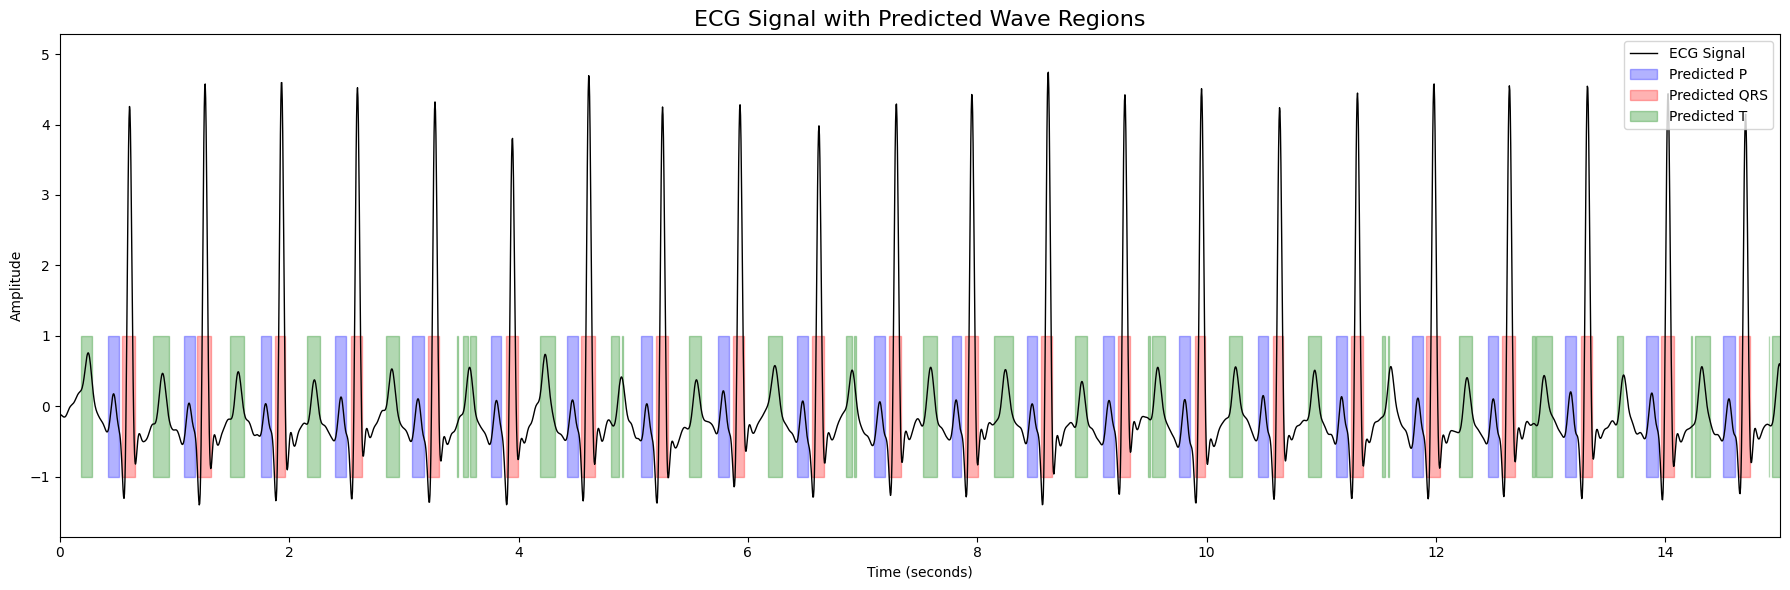

In [33]:

#record = wfdb.rdrecord('/content/drive/MyDrive/Final project/dataset/physionet.org/files/ecgiddb/1.0.0/Person_48/rec_1')

#record = wfdb.rdrecord('/content/drive/MyDrive/Final project/dataset/physionet.org/files/ecgiddb/1.0.0/Person_48/rec_1')

record = wfdb.rdrecord(path+'/physionet.org/files/mitdb/1.0.0/205')
signal = record.p_signal[:, 0]  # lead I
fs = record.fs
signal=signal[(10):(25*fs)]

# Predict
pred_labels, segments, _ = predict_full_ecg(signal, model, fs=fs)
signal = np.concatenate(segments, axis=2)
signal = signal.reshape(-1)
print(len(signal))
# Extract wave start/end
boundaries = get_wave_boundaries(pred_labels)
print(boundaries)
visualize_boundaries(signal, boundaries, fs=250, zoom=(0, 15))

6000
{'P': [(79, 104), (278, 297), (471, 493), (665, 686), (850, 873), (1039, 1057), (1230, 1252), (1415, 1441), (1602, 1621), (1782, 1804), (1914, 1919), (1966, 1985), (2148, 2170), (2331, 2357), (2517, 2540), (2699, 2722), (2872, 2879), (2882, 2905), (3078, 3098), (3263, 3284), (3440, 3461), (3625, 3646), (3808, 3831), (3999, 4020), (4184, 4207), (4318, 4319), (4368, 4391), (4553, 4575), (4748, 4770), (4933, 4954), (5110, 5132), (5291, 5316), (5473, 5501), (5666, 5690)], 'QRS': [(115, 150), (304, 338), (498, 532), (690, 726), (879, 915), (1064, 1101), (1258, 1293), (1449, 1482), (1626, 1659), (1661, 1662), (1810, 1845), (1990, 2027), (2175, 2212), (2365, 2396), (2400, 2402), (2548, 2584), (2726, 2763), (2915, 2950), (3105, 3142), (3290, 3327), (3469, 3504), (3653, 3688), (3840, 3874), (4027, 4064), (4212, 4249), (4397, 4432), (4584, 4620), (4777, 4812), (4961, 4996), (5139, 5173), (5321, 5357), (5511, 5547), (5697, 5732), (5735, 5735), (5835, 5899)], 'T': [(0, 44), (168, 216), (225, 

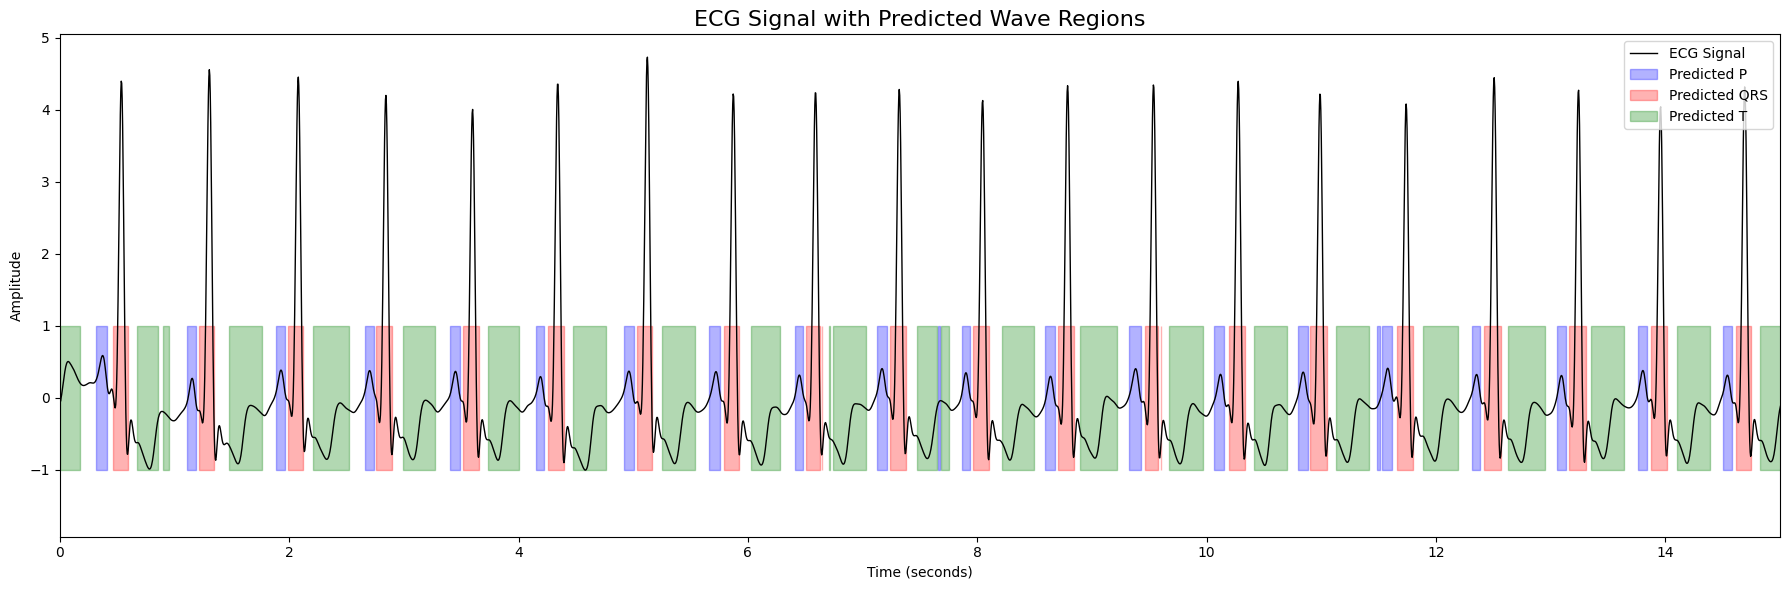

In [34]:

#record = wfdb.rdrecord('/content/drive/MyDrive/Final project/dataset/physionet.org/files/ecgiddb/1.0.0/Person_48/rec_1')

record = wfdb.rdrecord(path+'/physionet.org/files/mitdb/1.0.0/223')
signal = record.p_signal[:, 0]  # lead I
fs = record.fs
signal=signal[(10):(25*fs)]

# Predict
pred_labels, segments, _ = predict_full_ecg(signal, model, fs=fs)
signal = np.concatenate(segments, axis=2)
signal = signal.reshape(-1)
print(len(signal))
# Extract wave start/end
boundaries = get_wave_boundaries(pred_labels)
print(boundaries)
visualize_boundaries(signal, boundaries, fs=250, zoom=(0, 15))